# **Keras - Transfer Learning with Cats vs Dogs**

---

In this lesson, we learn how to setup data generators to load our own dataset and train a classifier using Keras.
1. Understand trainable layers of a Neural Network
2. Setting up our data
3. Building our Model for Transfer Learning
4. Perform Fine Tuning

In [ ]:
# Import of libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras

## **Trainable Layers**

Layers & models have **three** weight attributes:

- `weights` is the list of all weights variables of the layer.
- `trainable_weights` is the list of those that are meant to be updated (via gradient
 descent) to minimize the loss during training.
- `non_trainable_weights` is the list of those that aren't meant to be trained.
 Typically they are updated by the model during the forward pass.

**Example: the `Dense` layer has 2 trainable weights (kernel & bias)**

In [ ]:
layer = keras.layers.Dense(4)

# Create the weights using layer.build
layer.build((None, 2))

print(f'Number of weights: {len(layer.weights)}')
print(f'Number of trainable_weights: {len(layer.trainable_weights)}')
print(f'Number of non_trainable_weights: {len(layer.non_trainable_weights)}')

Number of weights: 2
Number of trainable_weights: 2
Number of non_trainable_weights: 0


**Layers & models** also feature a boolean attribute `trainable`.

Its value can be changed by setting `layer.trainable` to `False` moves all the layer's weights from trainable to non-trainable.  

This is called **"freezing"** the layer: the state of a frozen layer won't
be updated during training (either when training with `fit()` or when training with
 any custom loop that relies on `trainable_weights` to apply gradient updates).

### **Example: setting `trainable` to `False`**

In [ ]:
# Make a model with 2 layers
layer1 = keras.layers.Dense(3, activation="relu")
layer2 = keras.layers.Dense(3, activation="sigmoid")
model = keras.Sequential([keras.Input(shape=(3,)), layer1, layer2])

# Freeze the first layer
layer1.trainable = False

# Keep a copy of the weights of layer1 for later reference
initial_layer1_weights_values = layer1.get_weights()

# Train the model
model.compile(optimizer="adam", loss="mse")
model.fit(np.random.random((2, 3)), np.random.random((2, 3)))

1/1 [==============================] - 4s 4s/step - loss: 0.1883


In [ ]:
# Check that the weights of layer1 have not changed during training
final_layer1_weights_values = layer1.get_weights()

if initial_layer1_weights_values[0].all() == final_layer1_weights_values[0].all():
  print('Weights unchanged')

if initial_layer1_weights_values[1].all() == final_layer1_weights_values[1].all():
  print('Weights unchanged')

Weights unchanged
Weights unchanged


## **Implementing Transfer Learning**

![](https://github.com/rajeevratan84/ModernComputerVision/blob/main/Screenshot%202021-05-11%20at%2011.49.01%20pm.png?raw=true)

## **Transfer-learning workflow**

1. We instantiate a **base model and load pre-trained weighs** into it.
2. **Freeze** all layers in the base model by setting `trainable = False`.
3. Create a **new model on top** of the output of one (or several) layers from the base
 model.
4. Train your new model on your new dataset.

### **Step 1. Load dataset from Tensorflow**

In [ ]:
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print(f'Number of training samples: {tf.data.experimental.cardinality(train_ds)}')
print(f'Number of validation samples: {tf.data.experimental.cardinality(validation_ds)}')
print(f'Number of test samples: {tf.data.experimental.cardinality(test_ds)}')

Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


These are the first 9 images in the training dataset -- as you can see, they're all
 different sizes.

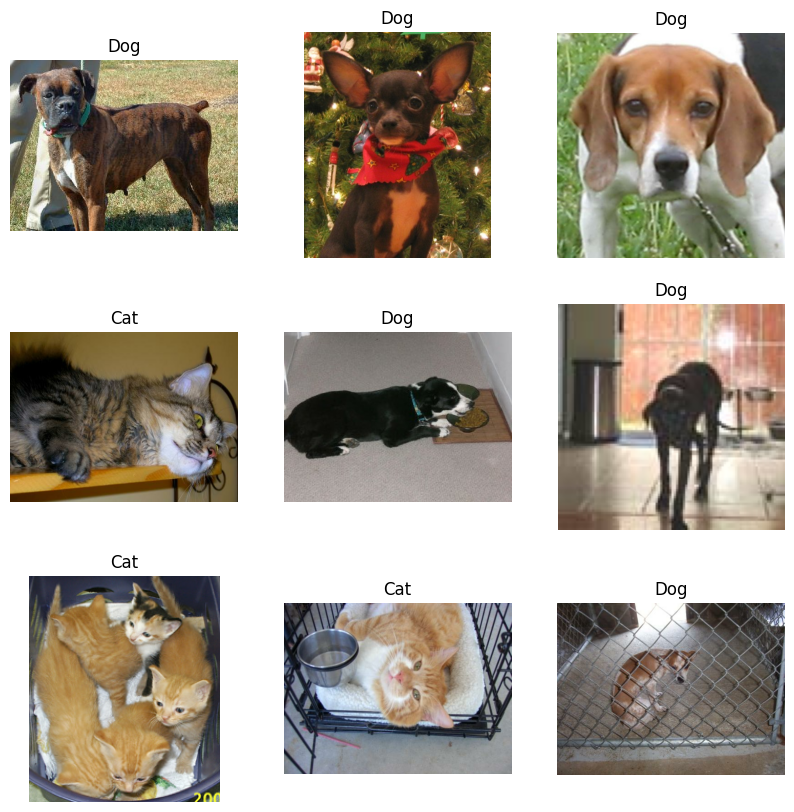

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title('Cat' if int(label) == 0 else 'Dog')
    plt.axis("off")

## **Standardize Our Data**

- Standardize to a fixed image size. We pick 150x150.
- Normalize pixel values between -1 and 1. We'll do this using a `Rescaling` layer as
 part of the model itself.

In [ ]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

We'll batch the data and use caching & prefetching to optimize loading speed.

In [ ]:
batch_size = 32

# optional
train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

### **Introduce some random data augmentation**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

#### **Visualize our Data Augmentations**

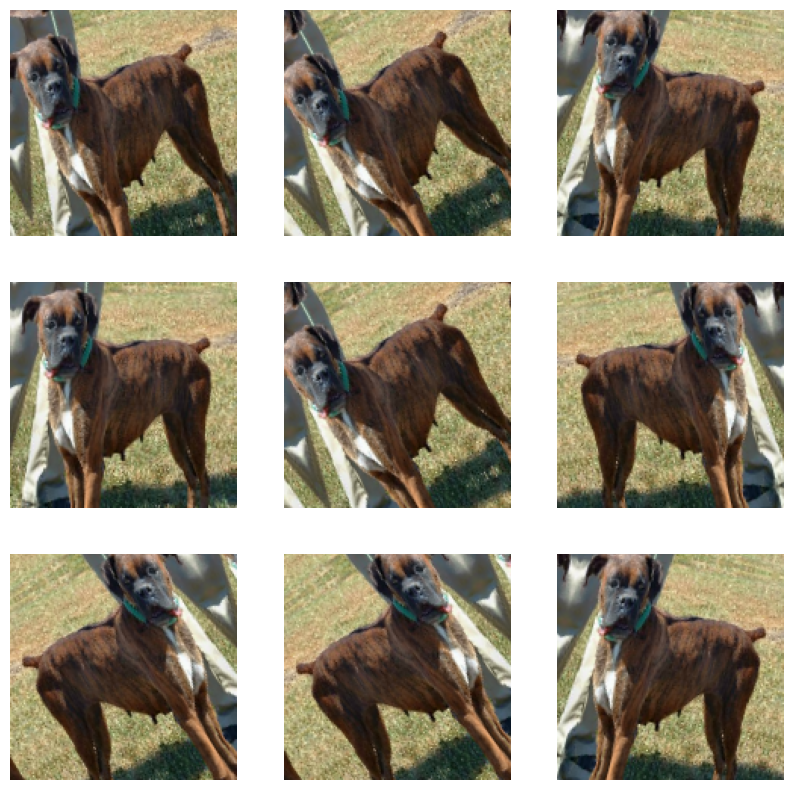

In [ ]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0)
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.axis("off")

## **3. Building our model**

Now let's built a model that follows the blueprint we've explained earlier.

Note that:

- We add a `Rescaling` layer to scale input values (initially in the `[0, 255]`
 range) to the `[-1, 1]` range.
- We add a `Dropout` layer before the classification layer, for regularization.
- We make sure to pass `training=False` when calling the base model, so that
it runs in inference mode.

- We'll be using the **Xception Model** as our base.

In [ ]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                           

## **Now let's Train our Top Layer**

Note from the above summary that we only have 2,049 trainable paramaters.

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
291/291 [==============================] - 28s 84ms/step - loss: 0.1574 - binary_accuracy: 0.9325 - val_loss: 0.0813 - val_binary_accuracy: 0.9686
Epoch 2/20
291/291 [==============================] - 24s 82ms/step - loss: 0.1166 - binary_accuracy: 0.9494 - val_loss: 0.0755 - val_binary_accuracy: 0.9703
Epoch 3/20
291/291 [==============================] - 23s 80ms/step - loss: 0.1080 - binary_accuracy: 0.9539 - val_loss: 0.0745 - val_binary_accuracy: 0.9733
Epoch 4/20
291/291 [==============================] - 23s 81ms/step - loss: 0.1030 - binary_accuracy: 0.9584 - val_loss: 0.0787 - val_binary_accuracy: 0.9678
Epoch 5/20
291/291 [==============================] - 24s 81ms/step - loss: 0.1066 - binary_accuracy: 0.9569 - val_loss: 0.0769 - val_binary_accuracy: 0.9712
Epoch 6/20
291/291 [==============================] - 24s 82ms/step - loss: 0.0997 - binary_accuracy: 0.9601 - val_loss: 0.0745 - val_binary_accuracy: 0.9708
Epoch 7/20
291/291 [==============================] 

## **4. Fine Tuning**

We **unfreeze** the base model and train the entire model end-to-end with a **low** learning rate.

**Notes** although the base model becomes trainable, it is still running in inference mode since we passed `training=False` when calling it when we built the model.

This means that the batch normalization layers inside won't update their batch statistics. If they did, they would wreck havoc on the representations learned by the model so far.

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                           